# Neural ODE Pendulum & Loss Landscapes

## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import numpy as np
import scipy as sci

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import copy

from scipy.special import ellipj, ellipk
from torch.optim.lr_scheduler import LinearLR

BATCH_SIZE = 50 # 150
WEIGHT_DECAY = 0
LEARNING_RATE = 5e-3 # 1e-2
NUMBER_EPOCHS = 1000 # 4000



def set_seed(seed=10):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def create_data(tmax=20, dt=1, theta0=2.0):
    """Solution for the nonlinear pendulum in theta space."""
    t = np.arange(0, tmax, dt)
    S = np.sin(0.5*(theta0) )
    K_S = ellipk(S**2)
    omega_0 = np.sqrt(9.81)
    sn,cn,dn,ph = ellipj( K_S - omega_0*t, S**2 )
    theta = 2.0*np.arcsin( S*sn )
    d_sn_du = cn*dn
    d_sn_dt = -omega_0 * d_sn_du
    d_theta_dt = 2.0*S*d_sn_dt / np.sqrt(1.0-(S*sn)**2)
    return np.stack([theta, d_theta_dt], axis=1)


def create_dataloader(x, batch_size=BATCH_SIZE):
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    dataset = torch.utils.data.TensorDataset(
        torch.tensor(np.asarray(x[0:-1]), dtype=torch.double),
        torch.tensor(np.asarray(x[1::]), dtype=torch.double),
    )

    test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader



def euler_step_func(f, x, dt):
    """The 'forward' Euler, a one stage Runge Kutta."""
    k1 = f(x)
    x_out = x + dt * k1
    return x_out

def rk4_step_func(f, x, dt):
    """The 'classic' RK4, a four stage Runge Kutta, O(Dt^4)."""
    k1 = f(x)
    x1 = x + 0.5 * dt * k1
    k2 = f(x1)
    x2 = x + 0.5 * dt * k2
    k3 = f(x2)
    x3 = x + dt * k3
    k4 = f(x3)
    x_out = x + dt * (1.0 / 6.0 * k1 + 1.0 / 3.0 * k2 + 1.0 / 3.0 * k3 +
                      1.0 / 6.0 * k4)
    return x_out


def shallow(in_dim, hidden, out_dim, Act=torch.nn.Tanh):
    """Just make a shallow network. This is more of a macro."""
    return torch.nn.Sequential(
        torch.nn.Linear(in_dim, hidden),
        Act(),
        torch.nn.Linear(hidden, out_dim), )


class ShallowODE(torch.nn.Module):
    """A basic shallow network that takes in a t as well"""

    def __init__(self, in_dim, out_dim, hidden=10, Act=torch.nn.Tanh, dt=None, method='euler'):
        super(ShallowODE, self).__init__()
        self.net = shallow(in_dim, hidden, out_dim, Act=Act)
        self.dt = dt
        self.method = method

    # def forward(self, x, h, dt, method='euler'):
    def forward(self, x):
        if self.method=='euler':
            #print(method)
            #for i in range(int(dt/h)):
            x = euler_step_func(self.net, x, self.dt)
            return x
        elif self.method=='rk4':
            #print(method)
            #for i in range(int(dt/h)):
            x = rk4_step_func(self.net, x, self.dt)
            return x


def train(ODEnet, train_loader, test_loader, lr=LEARNING_RATE, wd=WEIGHT_DECAY, method='rk4', dt=0.1):

    optimizer_ODEnet = optim.Adam(ODEnet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    scheduler = LinearLR(optimizer_ODEnet, start_factor=0.5, total_iters=4)

    criterion = torch.nn.MSELoss()
    ode_loss_hist = []
    ode_loss_ave_hist = []
    ode_test_loss_hist = []
    ode_test_loss_ave_hist = []
    ODEnet_best = None

    # set integrator and time step methods
    ODEnet.dt = dt
    ODEnet.method = method

    print('ODENet Training')
    for epoch in range(1, NUMBER_EPOCHS):
        loss_ave = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer_ODEnet.zero_grad()
            outputs = ODEnet(inputs) # , h=dt, dt=dt, method=method)
            loss = criterion(outputs, targets)
            loss.backward()
            # TODO: do we step both?
            optimizer_ODEnet.step()
            scheduler.step()

            loss_ave += loss.item()
            ode_loss_hist.append(loss.item())
        ode_loss_ave_hist.append(loss_ave)

        # TODO: should we do this after each batch or each epoch?
        # TODO: should we use < or <= (first best or last best)
        # TODO: evaluate test loss instead
        test_loss_ave = 0.0
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = ODEnet(inputs)
            test_loss = criterion(outputs, targets)
            test_loss_ave += test_loss.item()
            # ode_test_loss_hist.append(test_loss.item())
        ode_test_loss_ave_hist.append(test_loss_ave)

        # TODO: save average test loss????
        # TODO: right now we take best batch

        if test_loss_ave <= min(ode_test_loss_ave_hist):
            #    # print(f'*** Found new best ODEnet (Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')
            print(f'*** Found new best ODEnet (Epoch: {epoch}, Test Loss: {test_loss_ave})')
            ODEnet_best = copy.deepcopy(ODEnet)

        #if loss.item() <= min(ode_loss_hist):
        #    # print(f'*** Found new best ODEnet (Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item()}')
        #    print(f'*** Found new best ODEnet (Epoch: {epoch}, Loss: {loss.item()}')
        #    ODEnet_best = copy.deepcopy(ODEnet)


        # if epoch % 10 == 0: print(f'Epoch: {epoch}, Loss: {loss_ave}, Test Loss: {test_loss_ave}, Best Test Loss: {min(ode_test_loss_ave_hist)}')
        if epoch % 10 == 0: print(f'Epoch: {epoch}, Loss: {loss_ave}, Test Loss: {test_loss_ave}')

    return ODEnet, ODEnet_best, ode_loss_hist



## Train models

Testing integrator = rk4
ODENet Training
*** Found new best ODEnet (Epoch: 1, Test Loss: 6.607874856118165)
*** Found new best ODEnet (Epoch: 2, Test Loss: 2.121182152773361)
*** Found new best ODEnet (Epoch: 3, Test Loss: 1.264531160720056)
*** Found new best ODEnet (Epoch: 4, Test Loss: 1.0527690658675872)
*** Found new best ODEnet (Epoch: 5, Test Loss: 0.7056115209754059)
*** Found new best ODEnet (Epoch: 6, Test Loss: 0.5196249460797137)
*** Found new best ODEnet (Epoch: 7, Test Loss: 0.4117853386213377)
*** Found new best ODEnet (Epoch: 8, Test Loss: 0.32459025208289966)
*** Found new best ODEnet (Epoch: 9, Test Loss: 0.26852394264125196)
*** Found new best ODEnet (Epoch: 10, Test Loss: 0.224772264257253)
Epoch: 10, Loss: 0.24812654207349935, Test Loss: 0.224772264257253
*** Found new best ODEnet (Epoch: 11, Test Loss: 0.19087079090636697)
*** Found new best ODEnet (Epoch: 12, Test Loss: 0.16284729845105145)
*** Found new best ODEnet (Epoch: 13, Test Loss: 0.13908637646743202)
***

*** Found new best ODEnet (Epoch: 115, Test Loss: 9.218969137422246e-05)
*** Found new best ODEnet (Epoch: 116, Test Loss: 9.127413856986e-05)
*** Found new best ODEnet (Epoch: 117, Test Loss: 9.036367464232013e-05)
*** Found new best ODEnet (Epoch: 118, Test Loss: 8.94582497499763e-05)
*** Found new best ODEnet (Epoch: 119, Test Loss: 8.855782535531153e-05)
*** Found new best ODEnet (Epoch: 120, Test Loss: 8.766236779522184e-05)
Epoch: 120, Loss: 8.821345840442865e-05, Test Loss: 8.766236779522184e-05
*** Found new best ODEnet (Epoch: 121, Test Loss: 8.677184429392858e-05)
*** Found new best ODEnet (Epoch: 122, Test Loss: 8.588622127870045e-05)
*** Found new best ODEnet (Epoch: 123, Test Loss: 8.500546458143329e-05)
*** Found new best ODEnet (Epoch: 124, Test Loss: 8.412954095069736e-05)
*** Found new best ODEnet (Epoch: 125, Test Loss: 8.325842026409059e-05)
*** Found new best ODEnet (Epoch: 126, Test Loss: 8.239207789838885e-05)
*** Found new best ODEnet (Epoch: 127, Test Loss: 8.15

*** Found new best ODEnet (Epoch: 219, Test Loss: 2.8687683169698206e-05)
*** Found new best ODEnet (Epoch: 220, Test Loss: 2.8381246463400393e-05)
Epoch: 220, Loss: 2.861026984327358e-05, Test Loss: 2.8381246463400393e-05
*** Found new best ODEnet (Epoch: 221, Test Loss: 2.8077524799388526e-05)
*** Found new best ODEnet (Epoch: 222, Test Loss: 2.777615657340201e-05)
*** Found new best ODEnet (Epoch: 223, Test Loss: 2.7476793293457727e-05)
*** Found new best ODEnet (Epoch: 224, Test Loss: 2.717913559145748e-05)
*** Found new best ODEnet (Epoch: 225, Test Loss: 2.6882974921361673e-05)
*** Found new best ODEnet (Epoch: 226, Test Loss: 2.6588234582276066e-05)
*** Found new best ODEnet (Epoch: 227, Test Loss: 2.629500084905444e-05)
*** Found new best ODEnet (Epoch: 228, Test Loss: 2.6003533693101392e-05)
*** Found new best ODEnet (Epoch: 229, Test Loss: 2.571424825297722e-05)
*** Found new best ODEnet (Epoch: 230, Test Loss: 2.5427663751339142e-05)
Epoch: 230, Loss: 2.5677136631905102e-05,

*** Found new best ODEnet (Epoch: 321, Test Loss: 9.851245699486751e-06)
*** Found new best ODEnet (Epoch: 322, Test Loss: 9.757071108749121e-06)
*** Found new best ODEnet (Epoch: 323, Test Loss: 9.642378428917934e-06)
*** Found new best ODEnet (Epoch: 324, Test Loss: 9.505271849296012e-06)
*** Found new best ODEnet (Epoch: 325, Test Loss: 9.345351166735916e-06)
*** Found new best ODEnet (Epoch: 326, Test Loss: 9.163989294352198e-06)
*** Found new best ODEnet (Epoch: 327, Test Loss: 8.964402973450179e-06)
*** Found new best ODEnet (Epoch: 328, Test Loss: 8.751458533099516e-06)
*** Found new best ODEnet (Epoch: 329, Test Loss: 8.531206435403975e-06)
*** Found new best ODEnet (Epoch: 330, Test Loss: 8.310201969465005e-06)
Epoch: 330, Loss: 8.290019300815735e-06, Test Loss: 8.310201969465005e-06
*** Found new best ODEnet (Epoch: 331, Test Loss: 8.094728071594203e-06)
*** Found new best ODEnet (Epoch: 332, Test Loss: 7.890071292326252e-06)
*** Found new best ODEnet (Epoch: 333, Test Loss: 

Epoch: 460, Loss: 6.288895292527803e-06, Test Loss: 1.4580549296870184e-05
Epoch: 470, Loss: 0.0002016162289485127, Test Loss: 0.0001932188103454851
*** Found new best ODEnet (Epoch: 476, Test Loss: 1.7103712022372642e-06)
*** Found new best ODEnet (Epoch: 477, Test Loss: 1.4006672991194493e-06)
*** Found new best ODEnet (Epoch: 478, Test Loss: 1.2697786527524162e-06)
*** Found new best ODEnet (Epoch: 479, Test Loss: 1.2575007428091312e-06)
Epoch: 480, Loss: 1.3749795950963629e-06, Test Loss: 1.2844796521085331e-06
*** Found new best ODEnet (Epoch: 481, Test Loss: 1.2488116362851306e-06)
*** Found new best ODEnet (Epoch: 482, Test Loss: 1.2149175522656888e-06)
*** Found new best ODEnet (Epoch: 485, Test Loss: 1.183286447805556e-06)
Epoch: 490, Loss: 1.5742831534832862e-05, Test Loss: 5.6513333728604667e-05
Epoch: 500, Loss: 0.00040187518618065417, Test Loss: 8.079837591206586e-05
*** Found new best ODEnet (Epoch: 507, Test Loss: 9.732213004297492e-07)
Epoch: 510, Loss: 1.03559592160470

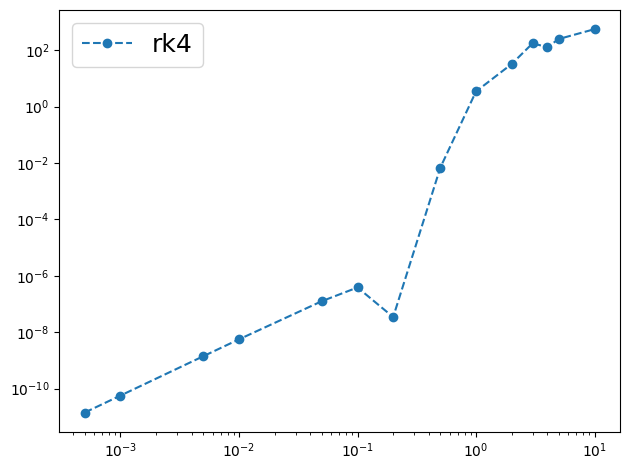

Testing integrator = euler
ODENet Training
*** Found new best ODEnet (Epoch: 1, Test Loss: 5.83656289436198)
*** Found new best ODEnet (Epoch: 2, Test Loss: 1.7703595218463455)
*** Found new best ODEnet (Epoch: 3, Test Loss: 1.2970817243971118)
*** Found new best ODEnet (Epoch: 4, Test Loss: 0.9227757492385646)
*** Found new best ODEnet (Epoch: 5, Test Loss: 0.5614083696772889)
*** Found new best ODEnet (Epoch: 6, Test Loss: 0.4226873932400793)
*** Found new best ODEnet (Epoch: 7, Test Loss: 0.30340030944920215)
*** Found new best ODEnet (Epoch: 8, Test Loss: 0.2370755185941276)
*** Found new best ODEnet (Epoch: 9, Test Loss: 0.186322772311601)
*** Found new best ODEnet (Epoch: 10, Test Loss: 0.14928300057954844)
Epoch: 10, Loss: 0.16889485627348874, Test Loss: 0.14928300057954844
*** Found new best ODEnet (Epoch: 11, Test Loss: 0.11915188693712038)
*** Found new best ODEnet (Epoch: 12, Test Loss: 0.09429928538034213)
*** Found new best ODEnet (Epoch: 13, Test Loss: 0.07328309551403533

*** Found new best ODEnet (Epoch: 122, Test Loss: 0.00010484261246701089)
*** Found new best ODEnet (Epoch: 123, Test Loss: 0.00010232789209174788)
*** Found new best ODEnet (Epoch: 124, Test Loss: 9.988797753157541e-05)
*** Found new best ODEnet (Epoch: 125, Test Loss: 9.75199500926819e-05)
*** Found new best ODEnet (Epoch: 126, Test Loss: 9.522101818173757e-05)
*** Found new best ODEnet (Epoch: 127, Test Loss: 9.298851286273905e-05)
*** Found new best ODEnet (Epoch: 128, Test Loss: 9.081988343603308e-05)
*** Found new best ODEnet (Epoch: 129, Test Loss: 8.871269305719559e-05)
*** Found new best ODEnet (Epoch: 130, Test Loss: 8.666461441076839e-05)
Epoch: 130, Loss: 8.785246517497445e-05, Test Loss: 8.666461441076839e-05
*** Found new best ODEnet (Epoch: 131, Test Loss: 8.467342545169013e-05)
*** Found new best ODEnet (Epoch: 132, Test Loss: 8.273700522498851e-05)
*** Found new best ODEnet (Epoch: 133, Test Loss: 8.08533297723141e-05)
*** Found new best ODEnet (Epoch: 134, Test Loss: 

*** Found new best ODEnet (Epoch: 250, Test Loss: 7.752486078724476e-06)
Epoch: 250, Loss: 7.839249068773412e-06, Test Loss: 7.752486078724476e-06
*** Found new best ODEnet (Epoch: 251, Test Loss: 7.626977092847867e-06)
*** Found new best ODEnet (Epoch: 252, Test Loss: 7.504143200927443e-06)
*** Found new best ODEnet (Epoch: 253, Test Loss: 7.383910062238175e-06)
*** Found new best ODEnet (Epoch: 254, Test Loss: 7.266200061846353e-06)
*** Found new best ODEnet (Epoch: 255, Test Loss: 7.150931321912219e-06)
*** Found new best ODEnet (Epoch: 256, Test Loss: 7.0380167132891704e-06)
*** Found new best ODEnet (Epoch: 257, Test Loss: 6.927362969840948e-06)
*** Found new best ODEnet (Epoch: 258, Test Loss: 6.8188700597526175e-06)
*** Found new best ODEnet (Epoch: 259, Test Loss: 6.712431030226349e-06)
*** Found new best ODEnet (Epoch: 260, Test Loss: 6.607932608815129e-06)
Epoch: 260, Loss: 6.678799707777506e-06, Test Loss: 6.607932608815129e-06
*** Found new best ODEnet (Epoch: 261, Test Los

*** Found new best ODEnet (Epoch: 376, Test Loss: 1.4524258544051793e-06)
*** Found new best ODEnet (Epoch: 377, Test Loss: 1.4382257941131818e-06)
*** Found new best ODEnet (Epoch: 378, Test Loss: 1.4250717056776703e-06)
*** Found new best ODEnet (Epoch: 379, Test Loss: 1.4132402111629172e-06)
*** Found new best ODEnet (Epoch: 380, Test Loss: 1.403079026380096e-06)
Epoch: 380, Loss: 1.6084390323450552e-06, Test Loss: 1.403079026380096e-06
*** Found new best ODEnet (Epoch: 381, Test Loss: 1.3950167492246847e-06)
*** Found new best ODEnet (Epoch: 382, Test Loss: 1.3895697020158569e-06)
*** Found new best ODEnet (Epoch: 383, Test Loss: 1.38734273325008e-06)
Epoch: 390, Loss: 1.596900805494005e-06, Test Loss: 1.517048882234962e-06
Epoch: 400, Loss: 1.4537387304381162e-06, Test Loss: 1.7327013024818665e-06
*** Found new best ODEnet (Epoch: 407, Test Loss: 1.3685949257626333e-06)
*** Found new best ODEnet (Epoch: 408, Test Loss: 1.3243916346372656e-06)
*** Found new best ODEnet (Epoch: 409,

[+] checkpoints/ODEnet_euler_dt_0.2_hidden_200_bs_50_lr_0.005_wd_0_seed_5544_epochs_1000_best.pt


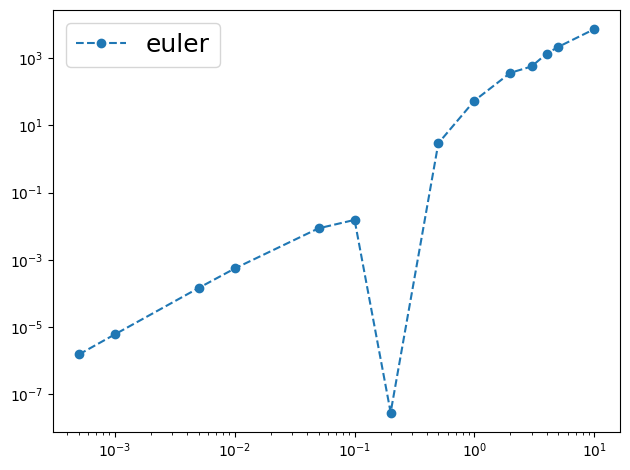

In [ ]:

# Press the green button in the gutter to run the script.
if __name__ == '__main__':

    # configure parameters
    dt = 0.2
    hidden = 200 # 100
    N_points = 500
    T_MAX = N_points * dt
    noise_loc = 0.0
    noise_scale = 1.0
    SEED = 5544
    set_seed(SEED)



    # TODO: loop over integrators
    integrators = ['euler', 'rk4'][::-1]
    for integrator in integrators:
        print(f"Testing integrator = {integrator}")


        # load the data
        x = create_data(tmax=T_MAX, dt=dt, theta0=2.0)
        x_ood_noise = x + np.random.normal(noise_loc, noise_scale, x.shape)
        train_loader, test_loader = create_dataloader(x)
        train_ood_noise_loader, test_ood_noise_loader = create_dataloader(x_ood_noise)

        # train OOD (different theta)
        x_ood_theta = create_data(tmax=T_MAX, dt=dt, theta0=2.5)
        train_ood_theta_loader, test_ood_theta_loader = create_dataloader(x_ood_theta)

        # try sequential split
        # _, train_loader = create_dataloader(x[:int(N_points * 0.80)])
        # _, test_loader = create_dataloader(x[int(N_points * 0.80):])



        ### train the model
        ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh, dt=dt, method=integrator).double()
        ODEnet, ODEnet_best, ode_loss_hist = train(ODEnet, copy.deepcopy(train_loader), copy.deepcopy(test_loader), method=integrator, dt=dt)

        # TODO: should we keep this as an option?
        use_best = True
        if use_best:
            ODEnet = ODEnet_best

        # TODO: save model checkpoints?
        checkpoint_file = f"checkpoints/ODEnet_{integrator}_dt_{dt}_hidden_{hidden}_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_wd_{WEIGHT_DECAY}_seed_{SEED}_epochs_{NUMBER_EPOCHS}.pt"
        if use_best:
            checkpoint_file = checkpoint_file.replace(".pt", "_best.pt")

        save_folder = os.path.dirname(checkpoint_file)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        torch.save({"model_state_dict": ODEnet}, checkpoint_file)
        print(f"[+] {checkpoint_file}")


        ### Evaluate the model --
        hs = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5, 10]
        error = []
        for h in hs:
            T_MAX = N_points * dt
            x = create_data(tmax=T_MAX, dt=h)
            _, eval_loader = create_dataloader(x)

            target_list = []
            output_list = []
            for batch_idx, (inputs, targets) in enumerate(eval_loader):
                ODEnet.dt = h
                ODEnet.method = integrator
                outputs = ODEnet(inputs) # h=h, dt=h, method=integrator
                output_list.append(outputs.detach().numpy())
                target_list.append(targets.numpy())

            error.append(np.mean(np.linalg.norm(np.vstack(output_list)-np.vstack(target_list), axis=1)**2))

        error = np.vstack(error)

        #fig = plt.figure()
        plt.plot(hs, error, 'o--', label=integrator)
        plt.yscale('log')
        plt.xscale('log')
        plt.legend(fontsize=18)
        plt.tight_layout()
        plt.show()

## Loss Landscape Analysis

### Approximate Hessian analysis using `HvP`

Here, we approximate the Hessian using the Hessian-vector Product (HvP). We compute the top eigenvalues and use the associated eigenvectors as directions for the loss landscape computation.

see, e.g.,
- https://www.lesswrong.com/posts/mwBaS2qE9RNNfqYBC/recipe-hessian-eigenvector-computation-for-pytorch-models


In [ ]:
import torch
from torch.autograd import grad
from scipy.sparse.linalg import LinearOperator, eigsh
import numpy as np
def get_hessian_eigenvectors(model, compute_loss_fn, train_data_loader, num_batches, device, n_top_vectors, param_extract_fn):
    """
    model: a pytorch model
    loss_fn: a pytorch loss function
    train_data_loader: a pytorch data loader
    num_batches: number of batches to use for the hessian calculation
    device: the device to use for the hessian calculation
    n_top_vectors: number of top eigenvalues / eigenvectors to return
    param_extract_fn: a function that takes a model and returns a list of parameters to compute the hessian with respect to (pass None to use all parameters)
    returns: a tuple of (eigenvalues, eigenvectors)
    eigenvalues: a numpy array of the top eigenvalues, arranged in increasing order
    eigenvectors: a numpy array of the top eigenvectors, arranged in increasing order, shape (n_top_vectors, num_params)
    """
    param_extract_fn = param_extract_fn or (lambda x: x.parameters())
    num_params = sum(p.numel() for p in param_extract_fn(model))
    subset_images, subset_labels = [], []
    for batch_idx, (images, labels) in enumerate(train_data_loader):
        if batch_idx >= num_batches:
            break
        subset_images.append(images.to(device))
        subset_labels.append(labels.to(device))
    subset_images = torch.cat(subset_images)
    subset_labels = torch.cat(subset_labels)

    def hessian_vector_product(vector):
        model.zero_grad()
        grad_params = grad(compute_loss_fn(model, subset_images, subset_labels), param_extract_fn(model), create_graph=True)
        flat_grad = torch.cat([g.view(-1) for g in grad_params])
        grad_vector_product = torch.sum(flat_grad * vector)
        hvp = grad(grad_vector_product, param_extract_fn(model), retain_graph=True)
        return torch.cat([g.contiguous().view(-1) for g in hvp])

    def matvec(v):
        v_tensor = torch.tensor(v, dtype=torch.float32, device=device)
        return hessian_vector_product(v_tensor).cpu().detach().numpy()

    linear_operator = LinearOperator((num_params, num_params), matvec=matvec)
    eigenvalues, eigenvectors = eigsh(linear_operator, k=n_top_vectors, tol=0.001, which='LM', return_eigenvectors=True)
    eigenvectors = np.transpose(eigenvectors)
    return eigenvalues, eigenvectors

### Loss Landscape Visualization

In [ ]:
# This is a simple function, that will allow us to perturb the model paramters and get the result
def get_params(model_orig,  model_perb, direction, alpha):
    for m_orig, m_perb, d in zip(model_orig.parameters(), model_perb.parameters(), direction):
        m_perb.data = m_orig.data + alpha * d
    return model_perb

Evaluating integrator='euler'
    eval_dt=0.2
        eval_loader=train
            [version 1] top_eigenvalues=array([2.06338848, 1.96030832, 1.71213247])
        eval_loader=test
            [version 1] top_eigenvalues=array([2.06338848, 1.96030832, 1.71213248])
        eval_loader=test_ood_noise
            [version 1] top_eigenvalues=array([1.99929777, 1.96505945, 1.71826265])
        eval_loader=test_ood_theta
            [version 1] top_eigenvalues=array([2.43632505, 2.3944259 , 1.7412579 ])
    eval_dt=0.01
        eval_loader=train
            [version 1] top_eigenvalues=array([0.02819225, 0.02815313, 0.02807293])
        eval_loader=test
            [version 1] top_eigenvalues=array([0.02819224, 0.02815299, 0.02807293])
        eval_loader=test_ood_noise
            [version 1] top_eigenvalues=array([ 0.03528243,  0.03493134, -0.03318432])
        eval_loader=test_ood_theta
            [version 1] top_eigenvalues=array([0.02850756, 0.02838382, 0.028307  ])
    eval_dt=0.1
    

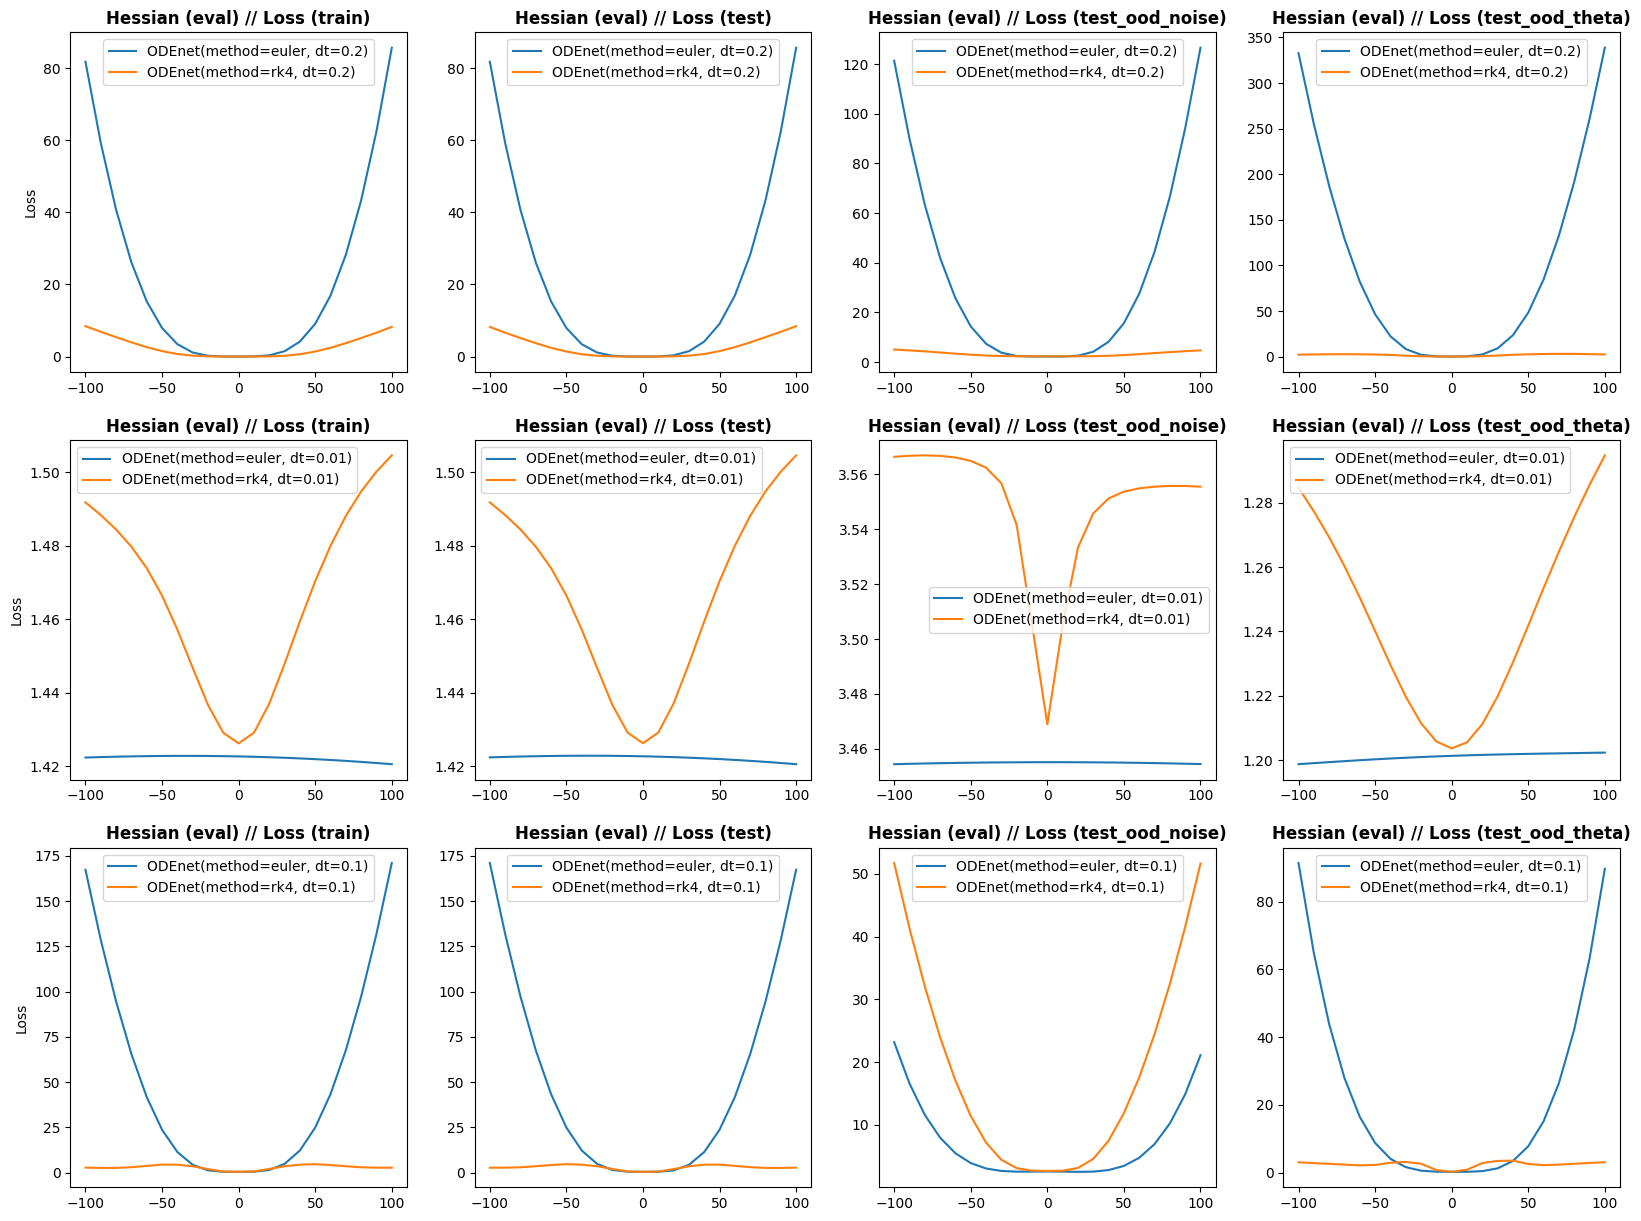

In [ ]:

### define params to loop over
# TODO: loop over integrators
integrators = ['euler', 'rk4']
eval_dts = [0.2, 0.01, 10e-2]

# TODO: create OOD loader (white noise?)
eval_loaders = [train_loader, test_loader, test_ood_noise_loader, test_ood_theta_loader]
eval_loader_names = ["train", "test", "test_ood_noise", "test_ood_theta"]


# TODO: should we keep this as an option?
use_best = True
num_batches = N_points//BATCH_SIZE
scale_distance = 200 # 200
device = "cpu"
criterion = torch.nn.MSELoss()


# use_hessian_loader = "train"
use_hessian_loader = "eval"



### create figures
nrows = len(eval_dts)
ncols = len(eval_loaders)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))


### loop over paramets
for integrator in integrators:

    print(f"Evaluating {integrator=}")

    # load model checkpoint
    checkpoint_file = f"checkpoints/ODEnet_{integrator}_dt_{dt}_hidden_{hidden}_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_wd_{WEIGHT_DECAY}_seed_{SEED}_epochs_{NUMBER_EPOCHS}.pt"
    if use_best:
        checkpoint_file = checkpoint_file.replace(".pt", "_best.pt")

    # construct model and load state dict
    ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh, dt=dt, method=integrator).double()
    checkpoint = torch.load(checkpoint_file)
    ODEnet = copy.deepcopy(checkpoint["model_state_dict"])

    ### loop over eval_dts
    for row, eval_dt in enumerate(eval_dts):
        print(f"    {eval_dt=}")

        for col, _ in enumerate(eval_loaders):
            eval_loader = copy.deepcopy(eval_loaders[col])
            print(f"        eval_loader={eval_loader_names[col]}")

            # reset seed each time for PyHessian stuff
            set_seed(seed=42)

            # define wrapper to compute loss
            def compute_loss(model, inputs, targets):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                return loss

            # set dt, integrator
            ODEnet.dt = eval_dt
            ODEnet.method = integrator

            # select loader to use for eigenvector computation
            # TODO: should we change how we compute Hessian eigs or always use train?
            if use_hessian_loader == "eval":
                hessian_loader = copy.deepcopy(eval_loader)
            else:
                loader_index = eval_loader_names.index(use_hessian_loader)
                hessian_loader = copy.deepcopy(eval_loaders[loader_index])



            ### Compute top Hessian eigenvectors

            # [version 1] compute eigenvectors
            top_eigenvalues, top_eigenvectors = get_hessian_eigenvectors(
                ODEnet, compute_loss, copy.deepcopy(hessian_loader), num_batches, 'cpu', 3, None
            )
            top_eigenvalues = top_eigenvalues[::-1]
            top_eigenvectors = top_eigenvectors[::-1, :]
            print(f"            [version 1] {top_eigenvalues=}")

            # [version 2] create the hessian computation module
            # from pyhessian import hessian
            # hessian_comp = hessian(ODEnet, criterion, data=(inputs, targets), cuda=False)
            # hessian_comp = hessian(ODEnet, criterion, dataloader=copy.deepcopy(hessian_loader), cuda=False)
            # top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=3)
            # top_eigenvalues = np.array(top_eigenvalues).round(8)
            # print(f"            [version 2] {top_eigenvalues=}")



            ### Compute Loss Landscape

            # to illustrate, let's use one batch for now
            subset_inputs, subset_targets = [], []
            for batch_idx, (inputs, targets) in enumerate(eval_loader):
                if batch_idx >= num_batches:
                    break
                subset_inputs.append(inputs.to(device))
                subset_targets.append(targets.to(device))
            inputs = torch.cat(subset_inputs)
            targets = torch.cat(subset_targets)


            # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors
            lams = np.linspace(-0.5*scale_distance, 0.5*scale_distance, 21).astype(np.float32)

            loss_list = []

            # create a copy of the model
            import copy
            model = copy.deepcopy(ODEnet)
            model_perb = copy.deepcopy(ODEnet)
            model_perb.eval()
            # model_perb = model_perb.cuda()

            # loop over steps, perturb model, and evaluate the loss
            for lam in lams:
                model_perb = get_params(model, model_perb, top_eigenvectors[0], lam)
                loss = compute_loss(model_perb, inputs, targets)
                loss_list.append(loss.item())

            # plot the loss landscape
            axes[row][col].plot(lams, loss_list, label=f"ODEnet(method={integrator}, dt={eval_dt})")
            if col == 0:
                axes[row][col].set_ylabel('Loss')
            if row == len(axes):
                axes[row][col].set_xlabel('Perturbation')
            axes[row][col].set_title(f'Hessian ({use_hessian_loader}) // Loss ({eval_loader_names[col]})', fontweight="bold")
            axes[row][col].legend()



## [TODO] Exact Hessian analysis using `functorch`

Above, we use an approximation of the Hessian to visualize the loss landscape. Here, we want to analyze the full Hessian matrix using `functorch`.

see, e.g.,
- https://stackoverflow.com/questions/74900770/fast-way-to-calculate-hessian-matrix-of-model-parameters-in-pytorch

In [ ]:
# settings
integrator = "euler"
eval_dt = 0.2
num_batches = N_points//BATCH_SIZE
device = "cpu"
criterion = torch.nn.MSELoss()


# data
subset_inputs, subset_targets = [], []
for batch_idx, (inputs, targets) in enumerate(copy.deepcopy(train_loader)):
    if batch_idx >= num_batches:
        break
    subset_inputs.append(inputs.to(device))
    subset_targets.append(targets.to(device))
inputs = torch.cat(subset_inputs)
targets = torch.cat(subset_targets)

len(inputs)

499

In [ ]:

# TODO: load model checkpoints?
checkpoint_file = f"checkpoints/ODEnet_{integrator}_dt_{dt}_hidden_200_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_wd_{WEIGHT_DECAY}_seed_{SEED}_epochs_{NUMBER_EPOCHS}.pt"
if use_best:
    checkpoint_file = checkpoint_file.replace(".pt", "_best.pt")

# construct model and load state dict
ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh, dt=eval_dt, method=integrator).double()
checkpoint = torch.load(checkpoint_file)
ODEnet = copy.deepcopy(checkpoint["model_state_dict"])

# update settings
ODEnet.dt = eval_dt
ODEnet.method = integrator


In [ ]:
import torch
from functorch import make_functional, grad, hessian

model = copy.deepcopy(ODEnet)

func_model, params = make_functional(model)
named_params = dict(model.named_parameters())

def compute_loss(params, inputs, targets):
    outputs = func_model(params, inputs)
    loss = criterion(outputs, targets)
    return loss

num_param = sum(p.numel() for p in model.parameters())
print(f"num_param = {num_param}")

# torchfunc
H = hessian(compute_loss, argnums=0)(params, inputs, targets)
print(H[0][0].size())

H = torch.cat([torch.cat([e.flatten() for e in Hpart]) for Hpart in H]) # flatten
H = H.reshape(num_param, num_param)
print(H.shape)

# using torch.autograd.functional
H = torch.autograd.functional.hessian(compute_loss, (params, inputs, targets), create_graph=False, strict=False, vectorize=False, outer_jacobian_strategy='reverse-mode')
print(H.shape)

eigenvalues, eigenvectors = torch.linalg.eig(H)

num_param = 1002
torch.Size([200, 2, 200, 2])
torch.Size([1002, 1002])


TypeError: The inputs given to hessian must be either a Tensor or a tuple of Tensors but the value at index 0 has type <class 'tuple'>.

<AxesSubplot: >

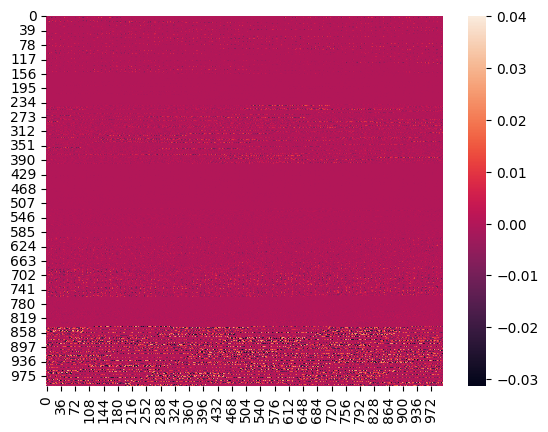

In [ ]:
import seaborn as sns
sns.heatmap(H.detach().numpy())

In [ ]:
eigenvalues, eigenvectors = torch.linalg.eig(H)
eigenvalues

tensor([ 1.2021e-01+0.0000j,  9.5350e-02+0.0682j,  9.5350e-02-0.0682j,
         ..., -5.0264e-04-0.0002j, -2.5677e-04+0.0000j,
        -8.1904e-05+0.0000j], dtype=torch.complex128,
       grad_fn=<LinalgEigBackward0>)

<BarContainer object of 1002 artists>

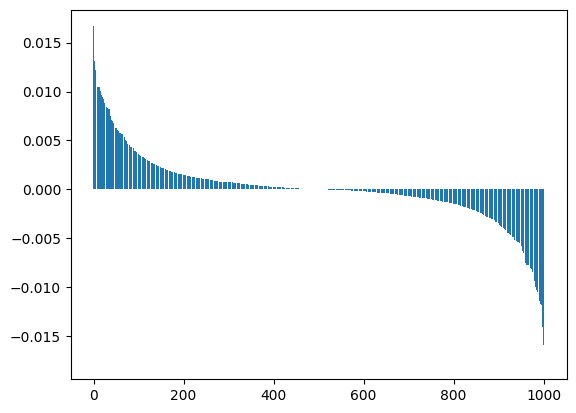

In [ ]:
plt.bar(np.arange(len(eigenvalues)), np.sort(eigenvalues.real.detach().numpy())[::-1])

array([ 0.01665531,  0.01665531,  0.01309593, ..., -0.01481866,
       -0.01597927, -0.01771606])

In [ ]:

### define params to loop over
# TODO: loop over integrators
integrators = ['euler', 'rk4']
eval_dts = [0.2, 0.01]

# TODO: create OOD loader (white noise?)
eval_loaders = [train_loader, test_loader, test_ood_noise_loader, test_ood_theta_loader]
eval_loader_names = ["train", "test", "test_ood_noise", "test_ood_theta"]


# TODO: should we keep this as an option?
use_best = True
num_batches = N_points//BATCH_SIZE
scale_distance = 200 # 200
device = "cpu"
criterion = torch.nn.MSELoss()


# use_hessian_loader = "train"
use_hessian_loader = "eval"



### create figures
nrows = len(eval_dts)
ncols = len(eval_loaders)
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*5))


### loop over paramets
for integrator in integrators:

    print(f"Evaluating {integrator=}")

    # load model checkpoint
    checkpoint_file = f"checkpoints/ODEnet_{integrator}_dt_{dt}_hidden_{hidden}_bs_{BATCH_SIZE}_lr_{LEARNING_RATE}_wd_{WEIGHT_DECAY}_seed_{SEED}_epochs_{NUMBER_EPOCHS}.pt"
    if use_best:
        checkpoint_file = checkpoint_file.replace(".pt", "_best.pt")

    # construct model and load state dict
    ODEnet = ShallowODE(in_dim=2, hidden=hidden, out_dim=2, Act=torch.nn.Tanh, dt=dt, method=integrator).double()
    checkpoint = torch.load(checkpoint_file)
    ODEnet = copy.deepcopy(checkpoint["model_state_dict"])

    ### loop over eval_dts
    for row, eval_dt in enumerate(eval_dts):
        print(f"    {eval_dt=}")

        for col, _ in enumerate(eval_loaders):
            eval_loader = copy.deepcopy(eval_loaders[col])
            print(f"        eval_loader={eval_loader_names[col]}")

            # reset seed each time for PyHessian stuff
            set_seed(seed=42)

            # define wrapper to compute loss
            def compute_loss(model, inputs, targets):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                return loss

            # set dt, integrator
            ODEnet.dt = eval_dt
            ODEnet.method = integrator

            # select loader to use for eigenvector computation
            # TODO: should we change how we compute Hessian eigs or always use train?
            if use_hessian_loader == "eval":
                hessian_loader = copy.deepcopy(eval_loader)
            else:
                loader_index = eval_loader_names.index(use_hessian_loader)
                hessian_loader = copy.deepcopy(eval_loaders[loader_index])



            ### Compute top Hessian eigenvectors

            # # [version 1] compute eigenvectors
            # top_eigenvalues, top_eigenvectors = get_hessian_eigenvectors(
            #     ODEnet, compute_loss, copy.deepcopy(hessian_loader), num_batches, 'cpu', 3, None
            # )
            # top_eigenvalues = top_eigenvalues[::-1]
            # top_eigenvectors = top_eigenvectors[::-1, :]
            # print(f"            [version 1] {top_eigenvalues=}")

            # [version 2] create the hessian computation module
            # from pyhessian import hessian
            # hessian_comp = hessian(ODEnet, criterion, data=(inputs, targets), cuda=False)
            # hessian_comp = hessian(ODEnet, criterion, dataloader=copy.deepcopy(hessian_loader), cuda=False)
            # top_eigenvalues, top_eigenvectors = hessian_comp.eigenvalues(top_n=3)
            # top_eigenvalues = np.array(top_eigenvalues).round(8)

            import torch
            from functorch import make_functional, grad, hessian

            model = copy.deepcopy(ODEnet)

            func_model, params = make_functional(model)
            named_params = dict(model.named_parameters())

            def compute_loss(params, inputs, targets):
                outputs = func_model(params, inputs)
                loss = criterion(outputs, targets)
                return loss

            num_param = sum(p.numel() for p in model.parameters())
            # print(f"num_param = {num_param}")

            H = hessian(compute_loss)(params, inputs, targets)
            # print(H[0][0].size()) # 2 x 2 x 1002 x 1002

            H = torch.cat([torch.cat([e.flatten() for e in Hpart]) for Hpart in H]) # flatten
            H = H.reshape(num_param, num_param)
            # print(H.shape)

            eigenvalues, eigenvectors = torch.linalg.eig(H)
            eigenvalues = eigenvalues.real.detach().numpy()
            eigenvectors = eigenvectors.real.detach().numpy()

            idx = np.argsort(eigenvalues)[::-1]
            eigenvalues = eigenvalues[idx]
            eigenvectors = eigenvectors[idx,:]
            top_eigenvalues = eigenvalues[:3]
            top_eigenvectors = eigenvectors[:3,:]
            print(f"            [version 2] {top_eigenvalues=}")



            ### Compute Loss Landscape

            # define wrapper to compute loss
            def compute_loss(model, inputs, targets):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                return loss


            # to illustrate, let's use one batch for now
            subset_inputs, subset_targets = [], []
            for batch_idx, (inputs, targets) in enumerate(eval_loader):
                if batch_idx >= num_batches:
                    break
                subset_inputs.append(inputs.to(device))
                subset_targets.append(targets.to(device))
            inputs = torch.cat(subset_inputs)
            targets = torch.cat(subset_targets)


            # lambda is a small scalar that we use to perturb the model parameters along the eigenvectors
            lams = np.linspace(-0.5*scale_distance, 0.5*scale_distance, 21).astype(np.float32)

            loss_list = []

            # create a copy of the model
            import copy
            model = copy.deepcopy(ODEnet)
            model_perb = copy.deepcopy(ODEnet)
            model_perb.eval()
            # model_perb = model_perb.cuda()

            # loop over steps, perturb model, and evaluate the loss
            for lam in lams:
                model_perb = get_params(model, model_perb, top_eigenvectors[0], lam)
                loss = compute_loss(model_perb, inputs, targets)
                loss_list.append(loss.item())

            # plot the loss landscape
            axes[row][col].plot(lams, loss_list, label=f"ODEnet(method={integrator}, dt={eval_dt})")
            if col == 0:
                axes[row][col].set_ylabel('Loss')
            if row == len(axes):
                axes[row][col].set_xlabel('Perturbation')
            axes[row][col].set_title(f'Hessian ({use_hessian_loader}) // Loss ({eval_loader_names[col]})', fontweight="bold")
            axes[row][col].legend()

